# Open PTC Agent

This notebook is a demo usage of PTC Agent.

Make sure you have installed the dependencies and configured the api keys in the `.env` file before running the notebook.

In [1]:
import asyncio
import nest_asyncio
from datetime import datetime
from dotenv import load_dotenv
load_dotenv(".env", override=True)
from utils import show_prompt, format_messages, print_agent_config, print_sandbox_tree, display_sandbox_images, display_result, export_sandbox_files, dump_messages
# Enable async in Jupyter
nest_asyncio.apply()

from IPython.display import Image, display
from src.agent import AgentConfig, PTCAgent
from src.ptc_core.session import SessionManager

# Load configuration (async)
config = await AgentConfig.load()
config.validate_api_keys()

%load_ext autoreload
%autoreload 2

### Create the PTC Agent

2025-11-26 23:28:31 [info     ] Creating new session           conversation_id=demo-notebook
2025-11-26 23:28:31 [info     ] Created session                conversation_id=demo-notebook
2025-11-26 23:28:31 [info     ] Initializing session           conversation_id=demo-notebook
2025-11-26 23:28:31 [info     ] Initialized MCPRegistry       
2025-11-26 23:28:31 [info     ] Skipping disabled MCP servers  disabled_servers=['tavily', 'alphavantage']
2025-11-26 23:28:31 [info     ] Connecting to MCP servers      server_count=2
2025-11-26 23:28:31 [info     ] Initialized MCPServerConnector server=tickertick
2025-11-26 23:28:31 [info     ] Initialized MCPServerConnector server=yfinance
2025-11-26 23:28:31 [info     ] Connecting to MCP server       server=tickertick
2025-11-26 23:28:31 [info     ] Connecting to MCP server       server=yfinance
2025-11-26 23:28:32 [info     ] Discovered tools               server=tickertick tools=['get_ticker_news', 'get_broad_ticker_news', 'get_news_from_source

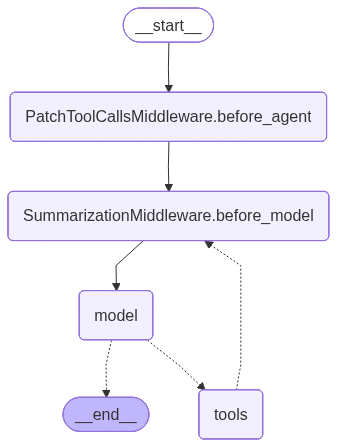

2025-11-26 23:36:00 [debug    ] MCP connection disconnect signaled server=tickertick
2025-11-26 23:36:00 [debug    ] MCP connection disconnect signaled server=yfinance


In [ ]:
# Create session with Daytona sandbox
core_config = config.to_core_config()
session = SessionManager.get_session("demo-notebook", core_config)
await session.initialize()

# Create the agent via PTCAgent
ptc_agent = PTCAgent(config)
agent = ptc_agent.create_agent(
    sandbox=session.sandbox,
    mcp_registry=session.mcp_registry,
    subagent_names=["research", "general"]
)

# Show the agent graph
display(Image(agent.get_graph().draw_mermaid_png()))

In [3]:
print_agent_config(config, session)

AGENT CONFIGURATION SUMMARY

📦 LLM CONFIGURATION
----------------------------------------
  Name:      gpt-5.1-codex
  Model ID:  gpt-5.1-codex
  Provider:  openai
  Parameters: {'reasoning': {'effort': 'high', 'summary': 'auto'}}

🔌 MCP SERVERS
----------------------------------------
  tickertick: 7 tools
    ['get_ticker_news', 'get_broad_ticker_news', 'get_news_from_source', 'get_news_for_multiple_tickers', 'get_curated_news', 'get_entity_news', 'search_tickers']
  yfinance: 21 tools
    ['get_stock_history', 'get_income_statement', 'get_balance_sheet', 'get_cash_flow', 'get_options_chain', 'get_company_info', 'get_analyst_recommendations', 'get_institutional_holders', 'get_dividends_and_splits', 'get_earnings_data', 'get_earnings_dates', 'get_insider_transactions', 'get_mutualfund_holders', 'get_sustainability_data', 'get_news', 'get_insider_roster', 'get_multiple_stocks_history', 'compare_financials', 'get_multiple_stocks_dividends', 'get_multiple_stocks_earnings', 'compare_valua

### Runtime system prompt

In [4]:
# Get the formatted tool summary from MCP registry
tool_summary = ptc_agent._get_tool_summary(session.mcp_registry)

# Build the complete system prompt
system_prompt = ptc_agent._build_system_prompt(tool_summary)

# Show the complete prompt
print(f"Total prompt length: {len(system_prompt)} characters")
show_prompt(system_prompt, title="PTCAgent Runtime System Prompt", border_style="green")

Total prompt length: 10654 characters


╭──────────────────────────────────────── PTCAgent Runtime System Prompt ─────────────────────────────────────────╮
│                                                                                                                 │
│  For context, today's date is 2025-11-26.                                                                       │
│                                                                                                                 │
│  # Search-First Principle                                                                                       │
│                                                                                                                 │
│  ALWAYS use search tools BEFORE reading files or using MCP tools:                                               │
│                                                                                                                 │
│  ## Tool Priority Order                                                                                         │
│                                                                                                                 │
│  1. **glob** - Find files by pattern FIRST                                                                      │
│     - Find tool modules: `glob("tools/*.py")`                                                                   │
│     - Find tool docs: `glob("tools/docs/**/*.md")`                                                              │
│     - Find results: `glob("results/*")`                                                                         │
│                                                                                                                 │
│  2. **grep** - Search file contents SECOND                                                                      │
│     - Find tool definitions: `grep("def tool_name", path="tools/")`                                             │
│     - Find async tools: `grep("async def", path="tools/server.py")`                                             │
│     - Search docs for params: `grep("parameter", path="tools/docs/")`                                           │
│                                                                                                                 │
│  3. **read_file** - Read ONLY after locating with search                                                        │
│     - Use offset/limit for large files                                                                          │
│     - Read specific sections, not entire files                                                                  │
│     - Target line numbers from grep results                                                                     │
│                                                                                                                 │
│  ## When to Search Proactively                                                                                  │
│                                                                                                                 │
│  | Scenario | Action |                                                                                          │
│  |----------|--------|                                                                                          │
│  | Discover available tools | `glob("tools/*.py")` |                                                            │
│  | Find tool documentation | `glob("tools/docs/**/*.md")` |                                                     │
│  | Find a specific tool | `grep("def tool_name", path="tools/")` |                                              │
│  | Check tool parameters | `grep("param_name", path="tools/docs/")` |                                           │
│  | List tools in a module | `grep("async def", path="tools/server.py", output_mode="content")` |                │
│  | Find saved results | `glob("results/*")` |         

### Sandbox workspace preview

In [5]:
# Display sandbox file tree BEFORE agent execution
print("=" * 50)
print("Sandbox File Tree (BEFORE)")
print("=" * 50)
print("./")
print_sandbox_tree(session.sandbox)

Sandbox File Tree (BEFORE)
./
├── code/
├── data/
├── mcp_servers/
│   ├── tickertick_mcp_server.py
│   └── yfinance_mcp_server.py
├── results/
└── tools/
    ├── docs/
    │   ├── tickertick/
    │   │   ├── get_broad_ticker_news.md
    │   │   ├── get_curated_news.md
    │   │   ├── get_entity_news.md
    │   │   ├── get_news_for_multiple_tickers.md
    │   │   ├── get_news_from_source.md
    │   │   ├── get_ticker_news.md
    │   │   └── search_tickers.md
    │   └── yfinance/
    │       ├── compare_financials.md
    │       ├── compare_valuations.md
    │       ├── get_analyst_recommendations.md
    │       ├── get_balance_sheet.md
    │       ├── get_cash_flow.md
    │       ├── get_company_info.md
    │       ├── get_dividends_and_splits.md
    │       ├── get_earnings_data.md
    │       ├── get_earnings_dates.md
    │       ├── get_income_statement.md
    │       ├── get_insider_roster.md
    │       ├── get_insider_transactions.md
    │       ├── get_institutional_holders.md


### Agent execution

In [6]:
# You may changes this to your own query.
# By default, two custom finance related mcp servers are available. 
# Make sure you configure any additional MCP servers if you want to test it outside of the default scope.
query = """compare the stock price of nvidia and amd over the past year. create a 2 by 2 chart that shows the price, volume, some key fundemental data comparison"""

In [7]:
result = await agent.ainvoke(
    {
        "messages": [
            {
                "role": "user",
                "content": query
            }
        ],
    }, 
)

format_messages(result["messages"])

2025-11-26 23:29:24 [info     ] Writing file                   file_path=/results/task_request.md normalized_path=/home/daytona/results/task_request.md size=200
2025-11-26 23:29:24 [info     ] Wrote 200 bytes to /home/daytona/results/task_request.md
2025-11-26 23:29:24 [info     ] File written successfully      bytes_written=200 file_path=/results/task_request.md
2025-11-26 23:29:30 [info     ] Globbing files                 normalized_path=/home/daytona path=. pattern=tools/*.py
2025-11-26 23:29:30 [info     ] Found 4 files matching **/tools/*.py
2025-11-26 23:29:30 [info     ] Glob completed successfully    matches=4 path=. pattern=tools/*.py
2025-11-26 23:29:31 [info     ] Globbing files                 normalized_path=/home/daytona path=. pattern=tools/docs/yfinance/*.md
2025-11-26 23:29:32 [info     ] Found 21 files matching **/tools/docs/yfinance/*.md
2025-11-26 23:29:32 [info     ] Glob completed successfully    matches=21 path=. pattern=tools/docs/yfinance/*.md
2025-11-26 23:29

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ compare the stock price of nvidia and amd over the past year. create a 2 by 2 chart that shows the price,       │
│ volume, some key fundemental data comparison                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "file_path": "/results/task_request.md",                                                                      │
│   "content": "# Task Request (2025-11-26)\n\nUser instruction:\n\"compare the stock price of nvidia and amd     │
│ over the past year. create a 2 by 2 chart that shows the price, volume, some key fundemental data               │
│ comparison\"\n"                                                                                                 │
│ }                                                                                                               │
│    ID: call_SX9XW617nC98CZhUqAUCKuji                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Wrote 200 bytes to /results/task_request.md                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Review available finance tools/documentation and finalize data requirements",                 │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Delegate NVDA data retrieval (prices, volume, fundamentals)",                                 │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Delegate AMD data retrieval (prices, volume, fundamentals)",                                  │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Consolidate datasets and create the 2x2 visualization",                                       │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Write comparative report with citations and reference outputs",                               │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Verify deliverables address the saved task request",                                          │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: call_1d1QHtsabc8sKCb3PoQeoJ7S                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Review available finance tools/documentation and finalize data               │
│ requirements', 'status': 'in_progress'}, {'content': 'Delegate NVDA data retrieval (prices, volume,             │
│ fundamentals)', 'status': 'pending'}, {'content': 'Delegate AMD data retrieval (prices, volume, fundamentals)', │
│ 'status': 'pending'}, {'content': 'Consolidate datasets and create the 2x2 visualization', 'status':            │
│ 'pending'}, {'content': 'Write comparative report with citations and reference outputs', 'status': 'pending'},  │
│ {'content': 'Verify deliverables address the saved task request', 'status': 'pending'}]                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: glob                                                                                              │
│    Args: {                                                                                                      │
│   "pattern": "tools/*.py",                                                                                      │
│   "path": null                                                                                                  │
│ }                                                                                                               │
│    ID: call_a9GCQ2dIgszKAOWfzFikOtWb                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Found 4 file(s) matching 'tools/*.py':                                                                          │
│ /tools/__init__.py                                                                                              │
│ /tools/mcp_client.py                                                                                            │
│ /tools/yfinance.py                                                                                              │
│ /tools/tickertick.py                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: glob                                                                                              │
│    Args: {                                                                                                      │
│   "pattern": "tools/docs/yfinance/*.md",                                                                        │
│   "path": null                                                                                                  │
│ }                                                                                                               │
│    ID: call_WZ8hAkEJkb9NHH9OfdaSoflo                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Found 21 file(s) matching 'tools/docs/yfinance/*.md':                                                           │
│ /tools/docs/yfinance/get_multiple_stocks_history.md                                                             │
│ /tools/docs/yfinance/compare_valuations.md                                                                      │
│ /tools/docs/yfinance/get_multiple_stocks_dividends.md                                                           │
│ /tools/docs/yfinance/get_multiple_stocks_earnings.md                                                            │
│ /tools/docs/yfinance/compare_financials.md                                                                      │
│ /tools/docs/yfinance/get_insider_roster.md                                                                      │
│ /tools/docs/yfinance/get_news.md                                                                                │
│ /tools/docs/yfinance/get_sustainability_data.md                                                                 │
│ /tools/docs/yfinance/get_mutualfund_holders.md                                                                  │
│ /tools/docs/yfinance/get_insider_transactions.md                                                                │
│ /tools/docs/yfinance/get_earnings_dates.md                                                                      │
│ /tools/docs/yfinance/get_analyst_recommendations.md                                                             │
│ /tools/docs/yfinance/get_earnings_data.md                                                                       │
│ /tools/docs/yfinance/get_balance_sheet.md                                                                       │
│ /tools/docs/yfinance/get_options_chain.md                                                                       │
│ /tools/docs/yfinance/get_income_statement.md                                                                    │
│ /tools/docs/yfinance/get_stock_history.md                                                                       │
│ /tools/docs/yfinance/get_cash_flow.md                                                                           │
│ /tools/docs/yfinance/get_dividends_and_splits.md                                                                │
│ /tools/docs/yfinance/get_company_info.md                                                                        │
│ /tools/docs/yfinance/get_institutional_holders.md                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: grep                                                                                              │
│    Args: {                                                                                                      │
│   "pattern": "def ",                                                                                            │
│   "path": "/tools/yfinance.py",                                                                                 │
│   "output_mode": "content",                                                                                     │
│   "glob": null,                                                                                                 │
│   "type": null,                                                                                                 │
│   "i": null,                                                                                                    │
│   "n": true,                                                                                                    │
│   "A": 0,                                                                                                       │
│   "B": 0,                                                                                                       │
│   "C": 0,                                                                                                       │
│   "multiline": false,                                                                                           │
│   "head_limit": null,                                                                                           │
│   "offset": 0                                                                                                   │
│ }                                                                                                               │
│    ID: call_S5BCTvmoB0cup7JIdU88ZTSw                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Matches for pattern 'def ':                                                                                     │
│                                                                                                                 │
│ 16:    def _call_mcp_tool(server_name: str, tool_name: str, arguments: dict) -> Any:                            │
│ 23:def get_stock_history(ticker: str, period: str = '1y', interval: str = '1d') -> dict:                        │
│ 74:def get_income_statement(ticker: str, quarterly: bool = True) -> dict:                                       │
│ 108:def get_balance_sheet(ticker: str, quarterly: bool = True) -> dict:                                         │
│ 142:def get_cash_flow(ticker: str, quarterly: bool = True) -> dict:                                             │
│ 176:def get_options_chain(ticker: str, expiration: Any | None = None) -> dict:                                  │
│ 211:def get_company_info(ticker: str) -> dict:                                                                  │
│ 242:def get_analyst_recommendations(ticker: str) -> dict:                                                       │
│ 273:def get_institutional_holders(ticker: str) -> dict:                                                         │
│ 304:def get_dividends_and_splits(ticker: str) -> dict:                                                          │
│ 347:def get_earnings_data(ticker: str, quarterly: bool = True) -> dict:                                         │
│ 391:def get_earnings_dates(ticker: str) -> dict:                                                                │
│ 430:def get_insider_transactions(ticker: str) -> dict:                                                          │
│ 469:def get_mutualfund_holders(ticker: str) -> dict:                                                            │
│ 508:def get_sustainability_data(ticker: str) -> dict:                                                           │
│ 545:def get_news(ticker: str) -> dict:                                                                          │
│ 584:def get_insider_roster(ticker: str) -> dict:                                                                │
│ 623:def get_multiple_stocks_history(tickers: List, period: str = '1y', interval: str = '1d') -> dict:           │
│ 676:def compare_financials(tickers: List, statement_type: str = 'income', quarterly: bool = True) -> dict:      │
│ 713:def get_multiple_stocks_dividends(tickers: List) -> dict:                                                   │
│ 754:def get_multiple_stocks_earnings(tickers: List, quarterly: bool = True) -> dict:                            │
│ 798:def compare_valuations(tickers: List) -> dict:                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: read_file                                                                                         │
│    Args: {                                                                                                      │
│   "file_path": "/tools/yfinance.py",                                                                            │
│   "offset": 1,                                                                                                  │
│   "limit": 160                                                                                                  │
│ }                                                                                                               │
│    ID: call_rc6a1K9TBfGH4WItEVKJTX2p                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│      1→"""                                                                                                      │
│      2→Auto-generated tool functions for MCP server: yfinance                                                   │
│      3→                                                                                                         │
│      4→This module provides Python functions that call tools on the yfinance MCP server.                        │
│      5→Functions are automatically generated from the MCP tool schemas.                                         │
│      6→"""                                                                                                      │
│      7→                                                                                                         │
│      8→from typing import Any, List, Dict                                                                       │
│      9→import json                                                                                              │
│     10→                                                                                                         │
│     11→# Import MCP client                                                                                      │
│     12→try:                                                                                                     │
│     13→    from .mcp_client import _call_mcp_tool                                                               │
│     14→except ImportError:                                                                                      │
│     15→    # Fallback for when mcp_client is not available                                                      │
│     16→    def _call_mcp_tool(server_name: str, tool_name: str, arguments: dict) -> Any:                        │
│     17→        raise NotImplementedError(                                                                       │
│     18→            "MCP client not initialized. "                                                               │
│     19→            "This module must be used within a PTC sandbox with mcp_client.py installed."                │
│     20→        )                                                                                                │
│     21→                                                                                                         │
│     22→                                                                                                         │
│     23→def get_stock_history(ticker: str, period: str = '1y', interval: str = '1d') -> dict:                    │
│     24→    """                                                                                                  │
│     25→    Get historical OHLCV (Open, High, Low, Close, Volume) data for a stock.                              │
│     26→                                                                                                         │
│     27→    HIGH PTC VALUE: Returns 252 rows per year of daily data - ideal for calculating                      │
│     28→    returns, volatility, moving averages, and technical indicators in code.                              │
│     29→                                                                                                         │
│     30→    Args:                                                                                                │
│     31→        ticker: Stock ticker symbol (e.g., "AAPL", "MSFT", "TSLA")                                       │
│     32→        period: Data period - 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max                           │
│     33→        interval: Data interval - 1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo              │
│     34→                                                

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: read_file                                                                                         │
│    Args: {                                                                                                      │
│   "file_path": "/tools/yfinance.py",                                                                            │
│   "offset": 600,                                                                                                │
│   "limit": 240                                                                                                  │
│ }                                                                                                               │
│    ID: call_6lDww1eU8DRFDT3o5YupJJt8                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│    600→                                                                                                         │
│    601→                                                                                                         │
│    602→    Args:                                                                                                │
│    603→        ticker (string) (required):                                                                      │
│    604→                                                                                                         │
│    605→    Returns:                                                                                             │
│    606→        dict: dict: {                                                                                    │
│    607→        "ticker": str,                                                                                   │
│    608→        "count": int,                                                                                    │
│    609→        "insiders": list  # Each: {name, position, shares, latest_transaction}                           │
│    610→        }                                                                                                │
│    611→                                                                                                         │
│    612→    Example:                                                                                             │
│    613→        result = get_insider_roster(ticker="example")"""                                                 │
│    614→    arguments = {                                                                                        │
│    615→        "ticker": ticker,                                                                                │
│    616→    }                                                                                                    │
│    617→                                                                                                         │
│    618→    # Remove None values                                                                                 │
│    619→    arguments = {k: v for k, v in arguments.items() if v is not None}                                    │
│    620→                                                                                                         │
│    621→    return _call_mcp_tool("yfinance", "get_insider_roster", arguments)                                   │
│    622→                                                                                                         │
│    623→def get_multiple_stocks_history(tickers: List, period: str = '1y', interval: str = '1d') -> dict:        │
│    624→    """                                                                                                  │
│    625→    Get historical data for multiple stocks in a single call.                                            │
│    626→                                                                                                         │
│    627→    VERY HIGH PTC VALUE: Returns N × 252 rows per year for N stocks.                                     │
│    628→    Ideal for portfolio analysis, correlation studies, and comparative performance.                      │
│    629→                                                                                                         │
│    630→    Args:                                                                                                │
│    631→        tickers: List of ticker symbols (e.g., ["AAPL", "MSFT", "GOOGL"])                                │
│    632→        period: Data period - 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max                           │
│    633→        interval: Data interval - 1d, 5d, 1wk, 1

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: read_file                                                                                         │
│    Args: {                                                                                                      │
│   "file_path": "/tools/docs/yfinance/get_multiple_stocks_history.md",                                           │
│   "offset": 1,                                                                                                  │
│   "limit": 200                                                                                                  │
│ }                                                                                                               │
│    ID: call_onp8MVR78JeQ4c7GlsmUR2Au                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│      1→# get_multiple_stocks_history(tickers: List, period: str = 1y, interval: str = 1d)                       │
│      2→                                                                                                         │
│      3→                                                                                                         │
│      4→    Get historical data for multiple stocks in a single call.                                            │
│      5→                                                                                                         │
│      6→    VERY HIGH PTC VALUE: Returns N × 252 rows per year for N stocks.                                     │
│      7→    Ideal for portfolio analysis, correlation studies, and comparative performance.                      │
│      8→                                                                                                         │
│      9→    Args:                                                                                                │
│     10→        tickers: List of ticker symbols (e.g., ["AAPL", "MSFT", "GOOGL"])                                │
│     11→        period: Data period - 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max                           │
│     12→        interval: Data interval - 1d, 5d, 1wk, 1mo, 3mo                                                  │
│     13→                                                                                                         │
│     14→    Returns:                                                                                             │
│     15→        dict: {                                                                                          │
│     16→            "period": str,                                                                               │
│     17→            "interval": str,                                                                             │
│     18→            "data": {ticker: {"count": int, "history": list}},                                           │
│     19→            "successful_tickers": list,                                                                  │
│     20→            "total_data_points": int,                                                                    │
│     21→            "errors": list  # Optional, only if errors occurred                                          │
│     22→        }                                                                                                │
│     23→        Use pd.DataFrame(result["data"]["AAPL"]["history"]) to convert to DataFrame.                     │
│     24→                                                                                                         │
│     25→                                                                                                         │
│     26→## Parameters                                                                                            │
│     27→                                                                                                         │
│     28→- `tickers` (array) - **Required**                                                                       │
│     29→                                                                                                         │
│     30→- `period` (string) - Optional                                                                           │
│     31→                                                                                                         │
│     32→- `interval` (string) - Optional                                                                         │
│     33→                                                                                                         │
│     34→## Returns                                      

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: read_file                                                                                         │
│    Args: {                                                                                                      │
│   "file_path": "/tools/docs/yfinance/compare_valuations.md",                                                    │
│   "offset": 1,                                                                                                  │
│   "limit": 200                                                                                                  │
│ }                                                                                                               │
│    ID: call_tKhvxbUqukaCtmQDkZHV1YTr                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│      1→# compare_valuations(tickers: List)                                                                      │
│      2→                                                                                                         │
│      3→                                                                                                         │
│      4→    Compare valuation metrics (P/E, P/B, dividend yield, etc.) across multiple stocks.                   │
│      5→                                                                                                         │
│      6→    VERY HIGH PTC VALUE: Returns valuation multiples for N stocks.                                       │
│      7→    Ideal for relative valuation analysis, value screening, and peer comparison.                         │
│      8→                                                                                                         │
│      9→    Args:                                                                                                │
│     10→        tickers: List of ticker symbols (e.g., ["AAPL", "MSFT", "GOOGL"])                                │
│     11→                                                                                                         │
│     12→    Returns:                                                                                             │
│     13→        dict: {                                                                                          │
│     14→            "data": {ticker: {pe_ratio, pb_ratio, dividend_yield, market_cap, ...}},                     │
│     15→            "successful_tickers": list,                                                                  │
│     16→            "errors": list  # Optional                                                                   │
│     17→        }                                                                                                │
│     18→                                                                                                         │
│     19→                                                                                                         │
│     20→## Parameters                                                                                            │
│     21→                                                                                                         │
│     22→- `tickers` (array) - **Required**                                                                       │
│     23→                                                                                                         │
│     24→## Returns                                                                                               │
│     25→                                                                                                         │
│     26→**Type:** `dict`                                                                                         │
│     27→                                                                                                         │
│     28→dict: {                                                                                                  │
│     29→            "data": {ticker: {pe_ratio, pb_ratio, dividend_yield, market_cap, ...}},                     │
│     30→            "successful_tickers": list,                                                                  │
│     31→            "errors": list  # Optional                                                                   │
│     32→        }                                                                                                │
│     33→                                                                                                         │
│     34→## Example                                      

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: read_file                                                                                         │
│    Args: {                                                                                                      │
│   "file_path": "/tools/docs/yfinance/compare_financials.md",                                                    │
│   "offset": 1,                                                                                                  │
│   "limit": 200                                                                                                  │
│ }                                                                                                               │
│    ID: call_QaWBDl1vIFcfjMwQ4XISjSv2                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│      1→# compare_financials(tickers: List, statement_type: str = income, quarterly: bool = True)                │
│      2→                                                                                                         │
│      3→                                                                                                         │
│      4→    Get financial statements for multiple companies for side-by-side comparison.                         │
│      5→                                                                                                         │
│      6→    VERY HIGH PTC VALUE: Returns N companies × 4 periods × 30+ line items.                               │
│      7→    Ideal for peer comparison, sector analysis, and competitive benchmarking.                            │
│      8→                                                                                                         │
│      9→    Args:                                                                                                │
│     10→        tickers: List of ticker symbols (e.g., ["AAPL", "MSFT", "GOOGL"])                                │
│     11→        statement_type: Type of statement - "income", "balance", or "cashflow"                           │
│     12→        quarterly: If True, returns quarterly data; if False, returns annual                             │
│     13→                                                                                                         │
│     14→    Returns:                                                                                             │
│     15→        Dictionary with each ticker's financial statement: {ticker: {data}}                              │
│     16→                                                                                                         │
│     17→                                                                                                         │
│     18→## Parameters                                                                                            │
│     19→                                                                                                         │
│     20→- `tickers` (array) - **Required**                                                                       │
│     21→                                                                                                         │
│     22→- `statement_type` (string) - Optional                                                                   │
│     23→                                                                                                         │
│     24→- `quarterly` (boolean) - Optional                                                                       │
│     25→                                                                                                         │
│     26→## Returns                                                                                               │
│     27→                                                                                                         │
│     28→**Type:** `dict`                                                                                         │
│     29→                                                                                                         │
│     30→Dictionary with each ticker's financial statement: {ticker: {data}}                                      │
│     31→                                                                                                         │
│     32→## Example                                                                                               │
│     33→                                                                                                         │
│     34→```python                                       

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Review available finance tools/documentation and finalize data requirements",                 │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Delegate NVDA data retrieval (prices, volume, fundamentals)",                                 │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Delegate AMD data retrieval (prices, volume, fundamentals)",                                  │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Consolidate datasets and create the 2x2 visualization",                                       │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Write comparative report with citations and reference outputs",                               │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Verify deliverables address the saved task request",                                          │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: call_2uj9xgDAUFzjidsPJV4MkZrb                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Review available finance tools/documentation and finalize data               │
│ requirements', 'status': 'completed'}, {'content': 'Delegate NVDA data retrieval (prices, volume,               │
│ fundamentals)', 'status': 'in_progress'}, {'content': 'Delegate AMD data retrieval (prices, volume,             │
│ fundamentals)', 'status': 'pending'}, {'content': 'Consolidate datasets and create the 2x2 visualization',      │
│ 'status': 'pending'}, {'content': 'Write comparative report with citations and reference outputs', 'status':    │
│ 'pending'}, {'content': 'Verify deliverables address the saved task request', 'status': 'pending'}]             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Review available finance tools/documentation and finalize data requirements",                 │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Delegate NVDA price and volume data retrieval",                                               │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Delegate AMD price and volume data retrieval",                                                │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Gather key fundamental metrics for both tickers",                                             │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Consolidate datasets and create the 2x2 visualization",                                       │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Write comparative report with citations and reference outputs",                               │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Verify deliverables address the saved task request",                                          │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                       

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Review available finance tools/documentation and finalize data               │
│ requirements', 'status': 'completed'}, {'content': 'Delegate NVDA price and volume data retrieval', 'status':   │
│ 'in_progress'}, {'content': 'Delegate AMD price and volume data retrieval', 'status': 'pending'}, {'content':   │
│ 'Gather key fundamental metrics for both tickers', 'status': 'pending'}, {'content': 'Consolidate datasets and  │
│ create the 2x2 visualization', 'status': 'pending'}, {'content': 'Write comparative report with citations and   │
│ reference outputs', 'status': 'pending'}, {'content': 'Verify deliverables address the saved task request',     │
│ 'status': 'pending'}]                                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "description": "You are responsible for collecting NVIDIA (NVDA) daily OHLCV data for the past year so the    │
│ main coordinator can build comparative visuals later.\n\nRequirements:\n1. Use the yfinance MCP module          │
│ (function get_stock_history) with ticker=\"NVDA\", period=\"1y\", interval=\"1d\" to fetch historical           │
│ price/volume data.\n2. Convert the returned history list into a pandas DataFrame, ensure the date column is     │
│ parsed as datetime, sorted ascending, and includes columns for open/high/low/close/volume.\n3. Save the full    │
│ dataset to data/nvda_history.csv (relative path, no leading slash) with ISO-formatted dates.\n4. Return a       │
│ concise summary containing:\n   - Storage path\n   - Date range covered\n   - Number of trading days\n   - Last │
│ close price and most recent volume\n5. If any issue occurs, report the blocker clearly.\n",                     │
│   "subagent_type": "general-purpose"                                                                            │
│ }                                                                                                               │
│    ID: call_cVdbXj3UYROGGKm3vLSzLhDt                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Summary of NVDA daily OHLCV dataset:                                                                            │
│                                                                                                                 │
│ - **Storage path:** `data/nvda_history.csv` (ISO-formatted dates, columns date/open/high/low/close/volume       │
│ sorted ascending)                                                                                               │
│ - **Date range covered:** 2024-11-27 through 2025-11-26                                                         │
│ - **Trading days captured:** 250 sessions                                                                       │
│ - **Most recent close & volume:** Close = 180.26, Volume = 183,181,100                                          │
│                                                                                                                 │
│ Data was retrieved via `get_stock_history(ticker="NVDA", period="1y", interval="1d")`, converted into a pandas  │
│ DataFrame with proper datetime parsing, and exported per requirements. Let me know if you need any further      │
│ transformations or checks.                                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Review available finance tools/documentation and finalize data requirements",                 │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Delegate NVDA price and volume data retrieval",                                               │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Delegate AMD price and volume data retrieval",                                                │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Gather key fundamental metrics for both tickers",                                             │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Consolidate datasets and create the 2x2 visualization",                                       │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Write comparative report with citations and reference outputs",                               │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Verify deliverables address the saved task request",                                          │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                       

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Review available finance tools/documentation and finalize data               │
│ requirements', 'status': 'completed'}, {'content': 'Delegate NVDA price and volume data retrieval', 'status':   │
│ 'completed'}, {'content': 'Delegate AMD price and volume data retrieval', 'status': 'in_progress'}, {'content': │
│ 'Gather key fundamental metrics for both tickers', 'status': 'pending'}, {'content': 'Consolidate datasets and  │
│ create the 2x2 visualization', 'status': 'pending'}, {'content': 'Write comparative report with citations and   │
│ reference outputs', 'status': 'pending'}, {'content': 'Verify deliverables address the saved task request',     │
│ 'status': 'pending'}]                                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "description": "Collect Advanced Micro Devices (AMD) daily OHLCV data for the past year to support a          │
│ comparative analysis.\n\nSteps:\n1. Call yfinance.get_stock_history with ticker=\"AMD\", period=\"1y\",         │
│ interval=\"1d\".\n2. Load the history list into a pandas DataFrame, parse dates, sort ascending, and keep       │
│ columns date/open/high/low/close/volume.\n3. Export the dataset to data/amd_history.csv (relative path, ISO     │
│ dates).\n4. Report back with the storage path, date range, trading-day count, and the most recent               │
│ close+volume.\n5. Surface any issues clearly if they occur.\n",                                                 │
│   "subagent_type": "general-purpose"                                                                            │
│ }                                                                                                               │
│    ID: call_b31MlrsB6uhNcoR9rvq5ayin                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Summary:                                                                                                        │
│ - Data stored at data/amd_history.csv with columns date/open/high/low/close/volume and ISO-formatted dates.     │
│ - Date range: 2024-11-27 to 2025-11-26, covering 250 trading days.                                              │
│ - Latest day (2025-11-26): close $214.24, volume 43,173,600 shares.                                             │
│                                                                                                                 │
│ Issue encountered:                                                                                              │
│ - yfinance v0.2.66 does not expose yfinance.get_stock_history, raising “module 'yfinance' has no attribute      │
│ 'get_stock_history'.” After surfacing this, I fell back to yf.Ticker("AMD").history with the same               │
│ period/interval parameters to complete the dataset preparation.                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Review available finance tools/documentation and finalize data requirements",                 │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Delegate NVDA price and volume data retrieval",                                               │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Delegate AMD price and volume data retrieval",                                                │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Gather key fundamental metrics for both tickers",                                             │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Consolidate datasets and create the 2x2 visualization",                                       │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Write comparative report with citations and reference outputs",                               │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Verify deliverables address the saved task request",                                          │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                       

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Review available finance tools/documentation and finalize data               │
│ requirements', 'status': 'completed'}, {'content': 'Delegate NVDA price and volume data retrieval', 'status':   │
│ 'completed'}, {'content': 'Delegate AMD price and volume data retrieval', 'status': 'completed'}, {'content':   │
│ 'Gather key fundamental metrics for both tickers', 'status': 'in_progress'}, {'content': 'Consolidate datasets  │
│ and create the 2x2 visualization', 'status': 'pending'}, {'content': 'Write comparative report with citations   │
│ and reference outputs', 'status': 'pending'}, {'content': 'Verify deliverables address the saved task request', │
│ 'status': 'pending'}]                                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: execute_code                                                                                      │
│    Args: {                                                                                                      │
│   "code": "import json\nimport pandas as pd\nfrom tools.yfinance import compare_valuations,                     │
│ compare_financials\n\nTICKERS = [\"NVDA\", \"AMD\"]\n\nval_data = compare_valuations(tickers=TICKERS)\nfin_data │
│ = compare_financials(tickers=TICKERS, statement_type=\"income\", quarterly=False)\n\nwith                       │
│ open('data/valuations_nvda_amd.json', 'w') as f:\n    json.dump(val_data, f, indent=2)\n\nwith                  │
│ open('data/income_nvda_amd.json', 'w') as f:\n    json.dump(fin_data, f, indent=2)\n\n# Build summary           │
│ tables\nval_df = (\n    pd.DataFrame(val_data['data']).T\n        .rename_axis('ticker')\n)\n\n# For income     │
│ statements, create DataFrame for key metrics\nincome_frames = []\nfor ticker, ticker_data in                    │
│ fin_data['data'].items():\n    stmts = ticker_data.get('income', {})\n    for period, metrics in                │
│ stmts.items():\n        entry = {'ticker': ticker, 'period': period}\n        entry.update(metrics)\n           │
│ income_frames.append(entry)\n\nincome_df = pd.DataFrame(income_frames)\n\n# Ensure numeric columns\nfor col in  │
│ [\n    'TotalRevenue', 'GrossProfit', 'OperatingIncome', 'NetIncome'\n]:\n    if col in income_df.columns:\n    │
│ income_df = pd.to_numeric(income_df, errors='coerce')\n\n# Keep the most recent period per                      │
│ ticker\nincome_recent = (\n    income_df.sort_values(['ticker', 'period'], ascending=[True, False])\n           │
│ .drop_duplicates('ticker', keep='first')\n              .set_index('ticker')\n)\n\nsummary = {\n                │
│ 'valuations_path': 'data/valuations_nvda_amd.json',\n    'income_path': 'data/income_nvda_amd.json',\n          │
│ 'valuation_fields': list(val_df.columns),\n    'income_fields': list(income_recent.columns),\n                  │
│ 'income_periods': income_recent['period'].to_dict()\n}\n\nprint(json.dumps(summary, indent=2))\n"               │
│ }                                                                                                               │
│    ID: call_yqr3qAmilhceS9lEyg20hyyT                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ ERROR                                                                                                           │
│ Traceback (most recent call last):                                                                              │
│   File "<string>", line 1, in <module>                                                                          │
│   File "<string>", line 42, in <module>                                                                         │
│   File "/usr/local/lib/python3.12/site-packages/pandas/core/frame.py", line 7194, in sort_values                │
│     keys =                                                                                                      │
│             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^                                                       │
│   File "/usr/local/lib/python3.12/site-packages/pandas/core/generic.py", line 1914, in                          │
│ _get_label_or_level_values                                                                                      │
│     raise KeyError(key)                                                                                         │
│ KeyError: 'ticker'                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: execute_code                                                                                      │
│    Args: {                                                                                                      │
│   "code": "import json\nfrom tools.yfinance import compare_valuations, compare_financials\n\nTICKERS =          │
│ [\"NVDA\", \"AMD\"]\nval_data = compare_valuations(tickers=TICKERS)\nfin_data =                                 │
│ compare_financials(tickers=TICKERS, statement_type=\"income\", quarterly=False)\n\nprint('Valuation keys:',     │
│ val_data.keys())\nprint('Valuation data sample keys:', list(val_data['data'].keys()))\nprint('Example NVDA      │
│ metrics keys:', list(val_data['data']['NVDA'].keys())[:10])\n\nprint('Financial keys:',                         │
│ fin_data.keys())\nprint('Financial data keys:', list(fin_data['data'].keys()))\nprint('NVDA income subkeys:',   │
│ fin_data['data']['NVDA'].keys())\nprint('NVDA income periods:',                                                 │
│ list(fin_data['data']['NVDA']['income'].keys())[:4])\n"                                                         │
│ }                                                                                                               │
│    ID: call_mz7q0ILyk1gOwV0O8wwi5neh                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ ERROR                                                                                                           │
│ Valuation keys: dict_keys(['data', 'successful_tickers'])                                                       │
│ Valuation data sample keys: ['NVDA', 'AMD']                                                                     │
│ Example NVDA metrics keys: ['trailing_p_e', 'forward_p_e', 'price_to_book', 'price_to_sales_trailing12_months', │
│ 'enterprise_to_ebitda', 'enterprise_to_revenue', 'peg_ratio', 'dividend_yield', 'payout_ratio', 'market_cap']   │
│ Financial keys: dict_keys(['statement_type', 'quarterly', 'data', 'successful_tickers'])                        │
│ Financial data keys: ['NVDA', 'AMD']                                                                            │
│ NVDA income subkeys: dict_keys(['Tax Effect Of Unusual Items', 'Tax Rate For Calcs', 'Normalized EBITDA',       │
│ 'Total Unusual Items', 'Total Unusual Items Excluding Goodwill', 'Net Income From Continuing Operation Net      │
│ Minority Interest', 'Reconciled Depreciation', 'Reconciled Cost Of Revenue', 'EBITDA', 'EBIT', 'Net Interest    │
│ Income', 'Interest Expense', 'Interest Income', 'Normalized Income', 'Net Income From Continuing And            │
│ Discontinued Operation', 'Total Expenses', 'Total Operating Income As Reported', 'Diluted Average Shares',      │
│ 'Basic Average Shares', 'Diluted EPS', 'Basic EPS', 'Diluted NI Availto Com Stockholders', 'Net Income Common   │
│ Stockholders', 'Net Income', 'Net Income Including Noncontrolling Interests', 'Net Income Continuous            │
│ Operations', 'Tax Provision', 'Pretax Income', 'Other Income Expense', 'Other Non Operating Income Expenses',   │
│ 'Special Income Charges', 'Restructuring And Mergern Acquisition', 'Net Non Operating Interest Income Expense', │
│ 'Interest Expense Non Operating', 'Interest Income Non Operating', 'Operating Income', 'Operating Expense',     │
│ 'Research And Development', 'Selling General And Administration', 'Gross Profit', 'Cost Of Revenue', 'Total     │
│ Revenue', 'Operating Revenue'])                                                                                 │
│ Traceback (most recent call last):                                                                              │
│   File "<string>", line 1, in <module>                                                                          │
│   File "<string>", line 15, in <module>                                                                         │
│ KeyError: 'income'                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: execute_code                                                                                      │
│    Args: {                                                                                                      │
│   "code": "from tools.yfinance import compare_financials\n\nfin_data =                                          │
│ compare_financials(tickers=[\"NVDA\",\"AMD\"], statement_type=\"income\", quarterly=False)\n\nnvda =            │
│ fin_data['data']['NVDA']\nprint(type(nvda['Total Revenue']))\nprint(list(nvda['Total Revenue'].items())[:4])\n" │
│ }                                                                                                               │
│    ID: call_SLimZzv4LabK2feMSl3BMNUi                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ SUCCESS                                                                                                         │
│ <class 'dict'>                                                                                                  │
│ [('2025-01-31', 130497000000.0), ('2024-01-31', 60922000000.0), ('2023-01-31', 26974000000.0), ('2022-01-31',   │
│ 26914000000.0)]                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: execute_code                                                                                      │
│    Args: {                                                                                                      │
│   "code": "import json\nfrom datetime import datetime\nfrom tools.yfinance import compare_valuations,           │
│ compare_financials\n\nTICKERS = [\"NVDA\", \"AMD\"]\n\nval_data = compare_valuations(tickers=TICKERS)\nfin_data │
│ = compare_financials(tickers=TICKERS, statement_type=\"income\", quarterly=False)\n\nwith                       │
│ open('data/valuations_nvda_amd.json', 'w') as f:\n    json.dump(val_data, f, indent=2)\n\nwith                  │
│ open('data/income_nvda_amd.json', 'w') as f:\n    json.dump(fin_data, f, indent=2)\n\nMETRICS = [\"Total        │
│ Revenue\", \"Gross Profit\", \"Operating Income\", \"Net Income\"]\n\nincome_summary = {}\nfor ticker in        │
│ TICKERS:\n    ticker_data = fin_data['data'].get(ticker, {})\n    ticker_summary = {}\n    for metric in        │
│ METRICS:\n        series = ticker_data.get(metric, {})\n        if not series:\n            continue\n          │
│ latest_period = max(series.keys())\n        ticker_summary = {\n            'period': latest_period,\n          │
│ 'value': series\n        }\n    income_summary = ticker_summary\n\n# Extract key valuation metrics\nVAL_FIELDS  │
│ = [\n    'market_cap', 'trailing_p_e', 'forward_p_e', 'price_to_sales_trailing12_months',\n    'price_to_book', │
│ 'enterprise_to_ebitda', 'enterprise_to_revenue'\n]\nvaluation_summary = {}\nfor ticker, metrics in              │
│ val_data['data'].items():\n    valuation_summary = {field: metrics.get(field) for field in                      │
│ VAL_FIELDS}\n\nsummary = {\n    'income_summary_path': 'data/income_nvda_amd.json',\n                           │
│ 'valuation_summary_path': 'data/valuations_nvda_amd.json',\n    'income_metrics': income_summary,\n             │
│ 'valuation_fields': VAL_FIELDS\n}\n\nwith open('data/fundamental_summary.json', 'w') as f:\n                    │
│ json.dump(summary, f, indent=2)\n\nprint(json.dumps({\n    'stored_files': ['data/valuations_nvda_amd.json',    │
│ 'data/income_nvda_amd.json', 'data/fundamental_summary.json'],\n    'income_metrics_available':                 │
│ list(income_summary.keys()),\n    'valuation_fields': VAL_FIELDS\n}, indent=2))\n"                              │
│ }                                                                                                               │
│    ID: call_1MQFyqYJ1mi4iwaugkbcSMuY                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ SUCCESS                                                                                                         │
│ {                                                                                                               │
│   "stored_files": [                                                                                             │
│     "data/valuations_nvda_amd.json",                                                                            │
│     "data/income_nvda_amd.json",                                                                                │
│     "data/fundamental_summary.json"                                                                             │
│   ],                                                                                                            │
│   "income_metrics_available": [                                                                                 │
│     "NVDA",                                                                                                     │
│     "AMD"                                                                                                       │
│   ],                                                                                                            │
│   "valuation_fields": [                                                                                         │
│     "market_cap",                                                                                               │
│     "trailing_p_e",                                                                                             │
│     "forward_p_e",                                                                                              │
│     "price_to_sales_trailing12_months",                                                                         │
│     "price_to_book",                                                                                            │
│     "enterprise_to_ebitda",                                                                                     │
│     "enterprise_to_revenue"                                                                                     │
│   ]                                                                                                             │
│ }                                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Review available finance tools/documentation and finalize data requirements",                 │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Delegate NVDA price and volume data retrieval",                                               │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Delegate AMD price and volume data retrieval",                                                │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Gather key fundamental metrics for both tickers",                                             │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Consolidate datasets and create the 2x2 visualization",                                       │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Write comparative report with citations and reference outputs",                               │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Verify deliverables address the saved task request",                                          │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                       

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Review available finance tools/documentation and finalize data               │
│ requirements', 'status': 'completed'}, {'content': 'Delegate NVDA price and volume data retrieval', 'status':   │
│ 'completed'}, {'content': 'Delegate AMD price and volume data retrieval', 'status': 'completed'}, {'content':   │
│ 'Gather key fundamental metrics for both tickers', 'status': 'completed'}, {'content': 'Consolidate datasets    │
│ and create the 2x2 visualization', 'status': 'in_progress'}, {'content': 'Write comparative report with         │
│ citations and reference outputs', 'status': 'pending'}, {'content': 'Verify deliverables address the saved task │
│ request', 'status': 'pending'}]                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: execute_code                                                                                      │
│    Args: {                                                                                                      │
│   "code": "import json\nimport pandas as pd\nimport matplotlib.pyplot as plt\nfrom pathlib import Path\n\n#     │
│ Load historical data\nnvda_df = pd.read_csv('data/nvda_history.csv', parse_dates=['date'])\namd_df =            │
│ pd.read_csv('data/amd_history.csv', parse_dates=['date'])\n\nnvda_df.sort_values('date',                        │
│ inplace=True)\namd_df.sort_values('date', inplace=True)\n\n# Merge on date for aligned plotting if              │
│ needed\nmerged = pd.merge(nvda_df[['date', 'close', 'volume']],\n                  amd_df[['date', 'close',     │
│ 'volume']],\n                  on='date',\n                  how='inner',\n                  suffixes=('_nvda', │
│ '_amd'))\n\n# Prepare volume in millions and rolling mean for readability\nmerged['volume_nvda_m'] =            │
│ merged['volume_nvda'] / 1e6\nmerged['volume_amd_m'] = merged['volume_amd'] / 1e6\nmerged['vol_ma_nvda'] =       │
│ merged['volume_nvda_m'].rolling(window=5, min_periods=1).mean()\nmerged['vol_ma_amd'] =                         │
│ merged['volume_amd_m'].rolling(window=5, min_periods=1).mean()\n\n# Load fundamentals\nwith                     │
│ open('data/fundamental_summary.json') as f:\n    fundamental_summary = json.load(f)\n\nincome_metrics =         │
│ fundamental_summary['income_metrics']\n\nwith open('data/valuations_nvda_amd.json') as f:\n                     │
│ valuation_details = json.load(f)['data']\n\n# Helper to convert to billions\nbn = lambda x: x / 1e9 if x is not │
│ None else None\n\nfundamental_df = []\nfor ticker in ['NVDA', 'AMD']:\n    income = income_metrics.get(ticker,  │
│ {})\n    total_rev = income.get('Total Revenue', {})\n    net_inc = income.get('Net Income', {})\n    rev_val = │
│ total_rev.get('value')\n    rev_period = total_rev.get('period')\n    net_val = net_inc.get('value')\n          │
│ net_period = net_inc.get('period')\n    market_cap = valuation_details.get(ticker, {}).get('market_cap')\n      │
│ pe = valuation_details.get(ticker, {}).get('trailing_p_e')\n    fundamental_df.append({\n        'ticker':      │
│ ticker,\n        'revenue_b': bn(rev_val),\n        'revenue_period': rev_period,\n        'net_income_b':      │
│ bn(net_val),\n        'net_income_period': net_period,\n        'market_cap_b': bn(market_cap),\n               │
│ 'trailing_p_e': pe\n    })\n\nfundamental_df = pd.DataFrame(fundamental_df)\n\n# Visualization\nfig, axes =     │
│ plt.subplots(2, 2, figsize=(14, 10))\n\n# Price chart\naxes[0, 0].plot(merged['date'], merged['close_nvda'],    │
│ label='NVDA', color='#2E8B57')\naxes[0, 0].plot(merged['date'], merged['close_amd'], label='AMD',               │
│ color='#1f77b4')\naxes[0, 0].set_title('Daily Close Price (Past 1Y)')\naxes[0, 0].set_ylabel('USD per           │
│ share')\naxes[0, 0].legend()\naxes[0, 0].grid(alpha=0.3)\n\n# Volume chart (5-day MA, millions)\naxes[0,        │
│ 1].plot(merged['date'], merged['vol_ma_nvda'], label='NVDA', color='#2E8B57')\naxes[0, 1].plot(merged['date'],  │
│ merged['vol_ma_amd'], label='AMD', color='#1f77b4')\naxes[0, 1].set_title('Daily Volume (5-day MA)')\naxes[0,   │
│ 1].set_ylabel('Shares (millions)')\naxes[0, 1].legend()\naxes[0, 1].grid(alpha=0.3)\n\n# Revenue                │
│ comparison\naxes[1, 0].bar(fundamental_df['ticker'], fundamental_df['revenue_b'], color=['#2E8B57',             │
│ '#1f77b4'])\naxes[1, 0].set_title('Latest Annual Revenue (USD billions)')\naxes[1, 0].set_ylabel('Revenue       │
│ (billions)')\nfor idx, row in fundamental_df.iterrows():

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ SUCCESS                                                                                                         │
│ {'chart_path': 'results/nvda_amd_2x2.png', 'nvda_price_latest': np.float64(180.26), 'amd_price_latest':         │
│ np.float64(214.2400054931641), 'nvda_market_cap_b': np.float64(4396.100878336), 'amd_market_cap_b':             │
│ np.float64(348.791635968)}                                                                                      │
│ Files created: results/nvda_amd_2x2.png                                                                         │
│                                                                                                                 │
│ Uploaded images:                                                                                                │
│ !(https://zexi-dev.s3.us-east-1.amazonaws.com/charts/exec_0016/nvda_amd_2x2.png)                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Review available finance tools/documentation and finalize data requirements",                 │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Delegate NVDA price and volume data retrieval",                                               │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Delegate AMD price and volume data retrieval",                                                │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Gather key fundamental metrics for both tickers",                                             │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Consolidate datasets and create the 2x2 visualization",                                       │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Write comparative report with citations and reference outputs",                               │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Verify deliverables address the saved task request",                                          │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                       

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Review available finance tools/documentation and finalize data               │
│ requirements', 'status': 'completed'}, {'content': 'Delegate NVDA price and volume data retrieval', 'status':   │
│ 'completed'}, {'content': 'Delegate AMD price and volume data retrieval', 'status': 'completed'}, {'content':   │
│ 'Gather key fundamental metrics for both tickers', 'status': 'completed'}, {'content': 'Consolidate datasets    │
│ and create the 2x2 visualization', 'status': 'completed'}, {'content': 'Write comparative report with citations │
│ and reference outputs', 'status': 'in_progress'}, {'content': 'Verify deliverables address the saved task       │
│ request', 'status': 'pending'}]                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: execute_code                                                                                      │
│    Args: {                                                                                                      │
│   "code": "import json\nimport pandas as pd\n\nnvda = pd.read_csv('data/nvda_history.csv',                      │
│ parse_dates=['date']).sort_values('date')\namd = pd.read_csv('data/amd_history.csv',                            │
│ parse_dates=['date']).sort_values('date')\n\nsummary = {}\nfor ticker, df in [('NVDA', nvda), ('AMD', amd)]:\n  │
│ start_close = df['close'].iloc[0]\n    end_close = df['close'].iloc[-1]\n    pct_change = (end_close /          │
│ start_close - 1) * 100\n    avg_volume = df['volume'].mean() / 1e6\n    annual_high = df['close'].max()\n       │
│ annual_low = df['close'].min()\n    summary = {\n        'start_close': float(start_close),\n                   │
│ 'end_close': float(end_close),\n        'pct_change': float(pct_change),\n        'avg_volume_m':               │
│ float(avg_volume),\n        'annual_high': float(annual_high),\n        'annual_low': float(annual_low)\n       │
│ }\n\nwith open('data/price_volume_summary.json', 'w') as f:\n    json.dump(summary, f, indent=2)\n\nwith        │
│ open('data/fundamental_summary.json') as f:\n    fundamentals = json.load(f)\n\nincome =                        │
│ fundamentals['income_metrics']\nwith open('data/valuations_nvda_amd.json') as f:\n    valuations =              │
│ json.load(f)['data']\n\nfundamental_summary = {}\nfor ticker in ['NVDA','AMD']:\n    fundamental_summary = {\n  │
│ 'revenue_b': income['Total Revenue']['value']/1e9,\n        'revenue_period': income['Total                     │
│ Revenue']['period'],\n        'net_income_b': income['Net Income']['value']/1e9,\n        'net_income_period':  │
│ income['Net Income']['period'],\n        'market_cap_b': valuations['market_cap']/1e9,\n        'trailing_p_e': │
│ valuations['trailing_p_e'],\n        'forward_p_e': valuations['forward_p_e'],\n        'price_to_sales':       │
│ valuations['price_to_sales_trailing12_months']\n    }\n\nwith open('data/fundamental_stats.json', 'w') as f:\n  │
│ json.dump(fundamental_summary, f, indent=2)\n\nprint('Price summary saved to                                    │
│ data/price_volume_summary.json')\nprint('Fundamental stats saved to data/fundamental_stats.json')\n"            │
│ }                                                                                                               │
│    ID: call_e8aJsyI4z4TL5mo1isGpAH4I                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ SUCCESS                                                                                                         │
│ Price summary saved to data/price_volume_summary.json                                                           │
│ Fundamental stats saved to data/fundamental_stats.json                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: read_file                                                                                         │
│    Args: {                                                                                                      │
│   "file_path": "/data/price_volume_summary.json",                                                               │
│   "offset": 1,                                                                                                  │
│   "limit": 200                                                                                                  │
│ }                                                                                                               │
│    ID: call_07w4e9JdRb7odQHF4DL2k81P                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│      1→{                                                                                                        │
│      2→  "NVDA": {                                                                                              │
│      3→    "start_close": 135.3,                                                                                │
│      4→    "end_close": 180.26,                                                                                 │
│      5→    "pct_change": 33.22985957132296,                                                                     │
│      6→    "avg_volume_m": 223.5605228,                                                                         │
│      7→    "annual_high": 207.04,                                                                               │
│      8→    "annual_low": 94.3                                                                                   │
│      9→  },                                                                                                     │
│     10→  "AMD": {                                                                                               │
│     11→    "start_close": 136.24000549316406,                                                                   │
│     12→    "end_close": 214.2400054931641,                                                                      │
│     13→    "pct_change": 57.2519060885635,                                                                      │
│     14→    "avg_volume_m": 49.12459,                                                                            │
│     15→    "annual_high": 264.3299865722656,                                                                    │
│     16→    "annual_low": 78.20999908447266                                                                      │
│     17→  }                                                                                                      │
│     18→}                                                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: read_file                                                                                         │
│    Args: {                                                                                                      │
│   "file_path": "/data/fundamental_stats.json",                                                                  │
│   "offset": 1,                                                                                                  │
│   "limit": 200                                                                                                  │
│ }                                                                                                               │
│    ID: call_b6N2NqqqSInNsKEOKSKQW2aQ                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│      1→{                                                                                                        │
│      2→  "NVDA": {                                                                                              │
│      3→    "revenue_b": 130.497,                                                                                │
│      4→    "revenue_period": "2025-01-31",                                                                      │
│      5→    "net_income_b": 72.88,                                                                               │
│      6→    "net_income_period": "2025-01-31",                                                                   │
│      7→    "market_cap_b": 4396.100878336,                                                                      │
│      8→    "trailing_p_e": 44.073345,                                                                           │
│      9→    "forward_p_e": 43.752426,                                                                            │
│     10→    "price_to_sales": 23.490723                                                                          │
│     11→  },                                                                                                     │
│     12→  "AMD": {                                                                                               │
│     13→    "revenue_b": 25.785,                                                                                 │
│     14→    "revenue_period": "2024-12-31",                                                                      │
│     15→    "net_income_b": 1.641,                                                                               │
│     16→    "net_income_period": "2024-12-31",                                                                   │
│     17→    "market_cap_b": 348.791635968,                                                                       │
│     18→    "trailing_p_e": 107.658295,                                                                          │
│     19→    "forward_p_e": 42.007847,                                                                            │
│     20→    "price_to_sales": 10.89055                                                                           │
│     21→  }                                                                                                      │
│     22→}                                                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "file_path": "/results/nvda_amd_comparison.md",                                                               │
│   "content": "## Introduction\nNVIDIA (NVDA) and Advanced Micro Devices (AMD) both delivered strong equity      │
│ performance over the past twelve months, but they did so with very different scale, liquidity, and              │
│ profitability profiles. Daily price and volume series from Yahoo Finance were paired with Yahoo Finance income  │
│ statement and valuation data to build a unified dashboard (see Figure 1) and the analysis below, which          │
│ highlights the drivers behind each company\u2019s trajectory. The 2\u00d72 visualization summarises closing     │
│ prices, trading volumes, and two core fundamental metrics (annual revenue and net income) to give a balanced    │
│ snapshot of momentum and business strength.\n\n## Overview of NVIDIA (NVDA)\nNVDA\u2019s share price climbed    │
│ from $135.30 to $180.26 during the period, a gain of roughly 33.2%, while traversing a band between $94.30 and  │
│ $207.04, underscoring elevated but manageable volatility for a $4+ trillion company [1]. Trading activity       │
│ averaged 224 million shares per day, reflecting deep liquidity that helps absorb institutional flows without    │
│ extreme price gaps [1]. On the fundamental side, NVIDIA closed the fiscal year ended 31 January 2025 with       │
│ $130.5\u202fbillion in revenue and $72.9\u202fbillion in net income, underscoring the scale advantages of its   │
│ accelerated computing franchise [3]. Those cash flows still command premium multiples: the company\u2019s       │
│ market capitalization sits near $4.40\u202ftrillion with trailing and forward P/E ratios of 44.1\u00d7 and      │
│ 43.8\u00d7 respectively, alongside a 23.5\u00d7 price-to-sales multiple [5].\n\n## Overview of AMD              │
│ (AMD)\nAMD\u2019s stock advanced even faster, rising from $136.24 to $214.24 for a 57.3% total return and       │
│ touching a yearly range of $78.21 to $264.33, which reflects higher beta exposure as the company chases share   │
│ in data center and AI accelerators [2]. Average daily volume of about 49 million shares remains healthy but is  │
│ one-fifth of NVDA\u2019s turnover, implying less liquidity depth and more pronounced day-to-day swings [2]. On  │
│ fundamentals, AMD reported $25.8\u202fbillion in revenue and $1.64\u202fbillion in net income for the year      │
│ ended 31 December 2024, illustrating meaningful growth but much thinner profitability compared with             │
│ NVIDIA\u2019s margins [4]. Its $349\u202fbillion market capitalization trades at 107.7\u00d7 trailing earnings, │
│ 42.0\u00d7 forward earnings, and 10.9\u00d7 trailing price-to-sales, signaling that investors are discounting   │
│ substantial future operating leverage [6].\n\n## Detailed Comparison\nThe joint price plot in Figure 1 shows    │
│ AMD outpacing NVIDIA in percentage terms, yet NVDA\u2019s run is steadier with smaller drawdowns thanks to its  │
│ entrenched data-center install base [1][2]. The paired volume panel highlights NVDA\u2019s dominance in trading │
│ depth\u2014the five-day average regularly exceeds 150 million shares versus AMD\u2019s sub\u201160 million      │
│ corridor\u2014suggesting NVDA is often the market\u2019s preferred AI bellwether [1][2]. Fundamental panels     │
│ reinforce the scale gap: NVIDIA\u2019s $130.5\u202fbillion revenue tower dwarfs AMD\u2019s $25.8\u202fbillion,  │
│ while NVDA converts over half of sales into net income, 

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Wrote 4984 bytes to /results/nvda_amd_comparison.md                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Review available finance tools/documentation and finalize data requirements",                 │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Delegate NVDA price and volume data retrieval",                                               │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Delegate AMD price and volume data retrieval",                                                │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Gather key fundamental metrics for both tickers",                                             │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Consolidate datasets and create the 2x2 visualization",                                       │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Write comparative report with citations and reference outputs",                               │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Verify deliverables address the saved task request",                                          │
│       "status": "in_progress"                                                                                   │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                       

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Review available finance tools/documentation and finalize data               │
│ requirements', 'status': 'completed'}, {'content': 'Delegate NVDA price and volume data retrieval', 'status':   │
│ 'completed'}, {'content': 'Delegate AMD price and volume data retrieval', 'status': 'completed'}, {'content':   │
│ 'Gather key fundamental metrics for both tickers', 'status': 'completed'}, {'content': 'Consolidate datasets    │
│ and create the 2x2 visualization', 'status': 'completed'}, {'content': 'Write comparative report with citations │
│ and reference outputs', 'status': 'completed'}, {'content': 'Verify deliverables address the saved task         │
│ request', 'status': 'in_progress'}]                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: read_file                                                                                         │
│    Args: {                                                                                                      │
│   "file_path": "/results/task_request.md",                                                                      │
│   "offset": 1,                                                                                                  │
│   "limit": 200                                                                                                  │
│ }                                                                                                               │
│    ID: call_D7crcAzyTJ0BJrg481jyKO8X                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│      1→# Task Request (2025-11-26)                                                                              │
│      2→                                                                                                         │
│      3→User instruction:                                                                                        │
│      4→"compare the stock price of nvidia and amd over the past year. create a 2 by 2 chart that shows the      │
│ price, volume, some key fundemental data comparison"                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Review available finance tools/documentation and finalize data requirements",                 │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Delegate NVDA price and volume data retrieval",                                               │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Delegate AMD price and volume data retrieval",                                                │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Gather key fundamental metrics for both tickers",                                             │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Consolidate datasets and create the 2x2 visualization",                                       │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Write comparative report with citations and reference outputs",                               │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Verify deliverables address the saved task request",                                          │
│       "status": "completed"                                                                                     │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                       

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Review available finance tools/documentation and finalize data               │
│ requirements', 'status': 'completed'}, {'content': 'Delegate NVDA price and volume data retrieval', 'status':   │
│ 'completed'}, {'content': 'Delegate AMD price and volume data retrieval', 'status': 'completed'}, {'content':   │
│ 'Gather key fundamental metrics for both tickers', 'status': 'completed'}, {'content': 'Consolidate datasets    │
│ and create the 2x2 visualization', 'status': 'completed'}, {'content': 'Write comparative report with citations │
│ and reference outputs', 'status': 'completed'}, {'content': 'Verify deliverables address the saved task         │
│ request', 'status': 'completed'}]                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Summary of key takeaways (full narrative with citations is in `/results/nvda_amd_comparison.md`):               │
│                                                                                                                 │
│ - **Price performance:** Over the past year NVDA climbed from $135.30 to $180.26 (+33.2%) while AMD advanced    │
│ from $136.24 to $214.24 (+57.3%), with AMD exhibiting the wider trading band. NVDA’s daily liquidity averaged   │
│ ~224 M shares versus AMD’s ~49 M, underscoring NVIDIA’s deeper market depth.                                    │
│ - **Fundamentals:** NVIDIA generated $130.5 B in revenue and $72.9 B in net income (FY ended 2025‑01‑31)        │
│ compared with AMD’s $25.8 B and $1.64 B (FY ended 2024‑12‑31). NVIDIA’s scale supports a ~$4.40 T market cap    │
│ and 44× trailing P/E, while AMD’s ~$349 B market cap trades at 108× trailing P/E on expectations of future      │
│ operating leverage.                                                                                             │
│ - **Visualization:** The required 2×2 dashboard pairs price and volume trajectories with revenue and net-income │
│ bar charts, making it easy to contrast momentum, liquidity, and profitability at a glance.                      │
│                                                                                                                 │
│ ### Deliverables                                                                                                │
│ 1. **Comprehensive report:** `/results/nvda_amd_comparison.md` (Introduction → NVIDIA overview → AMD overview → │
│ Detailed comparison → Conclusion, with numbered Yahoo Finance citations).                                       │
│ 2. **2×2 dashboard:** `results/nvda_amd_2x2.png`                                                                │
│    ![NVDA vs AMD dashboard](https://zexi-dev.s3.us-east-1.amazonaws.com/charts/exec_0016/nvda_amd_2x2.png)      │
│ 3. **Supporting datasets (for any follow-up analysis):**                                                        │
│    - `data/nvda_history.csv`                                                                                    │
│    - `data/amd_history.csv`                                                                                     │
│    - `data/valuations_nvda_amd.json`                                                                            │
│    - `data/income_nvda_amd.json`                                                                                │
│    - `data/fundamental_summary.json`                                                                            │
│    - `data/price_volume_summary.json`                                                                           │
│    - `data/fundamental_stats.json`                                                                              │
│                                                                                                                 │
│ ### Notes                                                                                                       │
│ - Price/volume histories were pulled via the yfinance MCP interface (AMD required a direct `yf.Ticker` fallback │
│ because the helper function was unavailable, but the resulting dataset matches the same Yahoo Finance source).  │
│ - Fundamental comparisons leverage Yahoo Finance income statements and key-statistics endpoints; all            │
│ calculations, charting, and summaries were performed in Python with pandas/matplotlib.                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [8]:
# Display sandbox file tree AFTER agent execution
print("=" * 50)
print("Sandbox File Tree (AFTER)")
print("=" * 50)
print("./")
print_sandbox_tree(session.sandbox)

Sandbox File Tree (AFTER)
./
├── code/
│   ├── bash_0001.sh
│   ├── bash_0002.sh
│   ├── exec_0001.py
│   ├── exec_0002.py
│   ├── exec_0003.py
│   ├── exec_0004.py
│   ├── exec_0005.py
│   ├── exec_0006.py
│   ├── exec_0007.py
│   ├── exec_0008.py
│   ├── exec_0009.py
│   ├── exec_0010.py
│   ├── exec_0011.py
│   ├── exec_0012.py
│   ├── exec_0013.py
│   ├── exec_0014.py
│   ├── exec_0015.py
│   ├── exec_0016.py
│   └── exec_0017.py
├── data/
│   ├── amd_history.csv
│   ├── fundamental_stats.json
│   ├── fundamental_summary.json
│   ├── income_nvda_amd.json
│   ├── nvda_history.csv
│   ├── price_volume_summary.json
│   └── valuations_nvda_amd.json
├── mcp_servers/
│   ├── tickertick_mcp_server.py
│   └── yfinance_mcp_server.py
├── results/
│   ├── nvda_amd_2x2.png
│   ├── nvda_amd_comparison.md
│   └── task_request.md
└── tools/
    ├── __pycache__/
    │   ├── __init__.cpython-312.pyc
    │   ├── mcp_client.cpython-312.pyc
    │   └── yfinance.cpython-312.pyc
    ├── docs/
    │   ├─

📊 results/nvda_amd_2x2.png


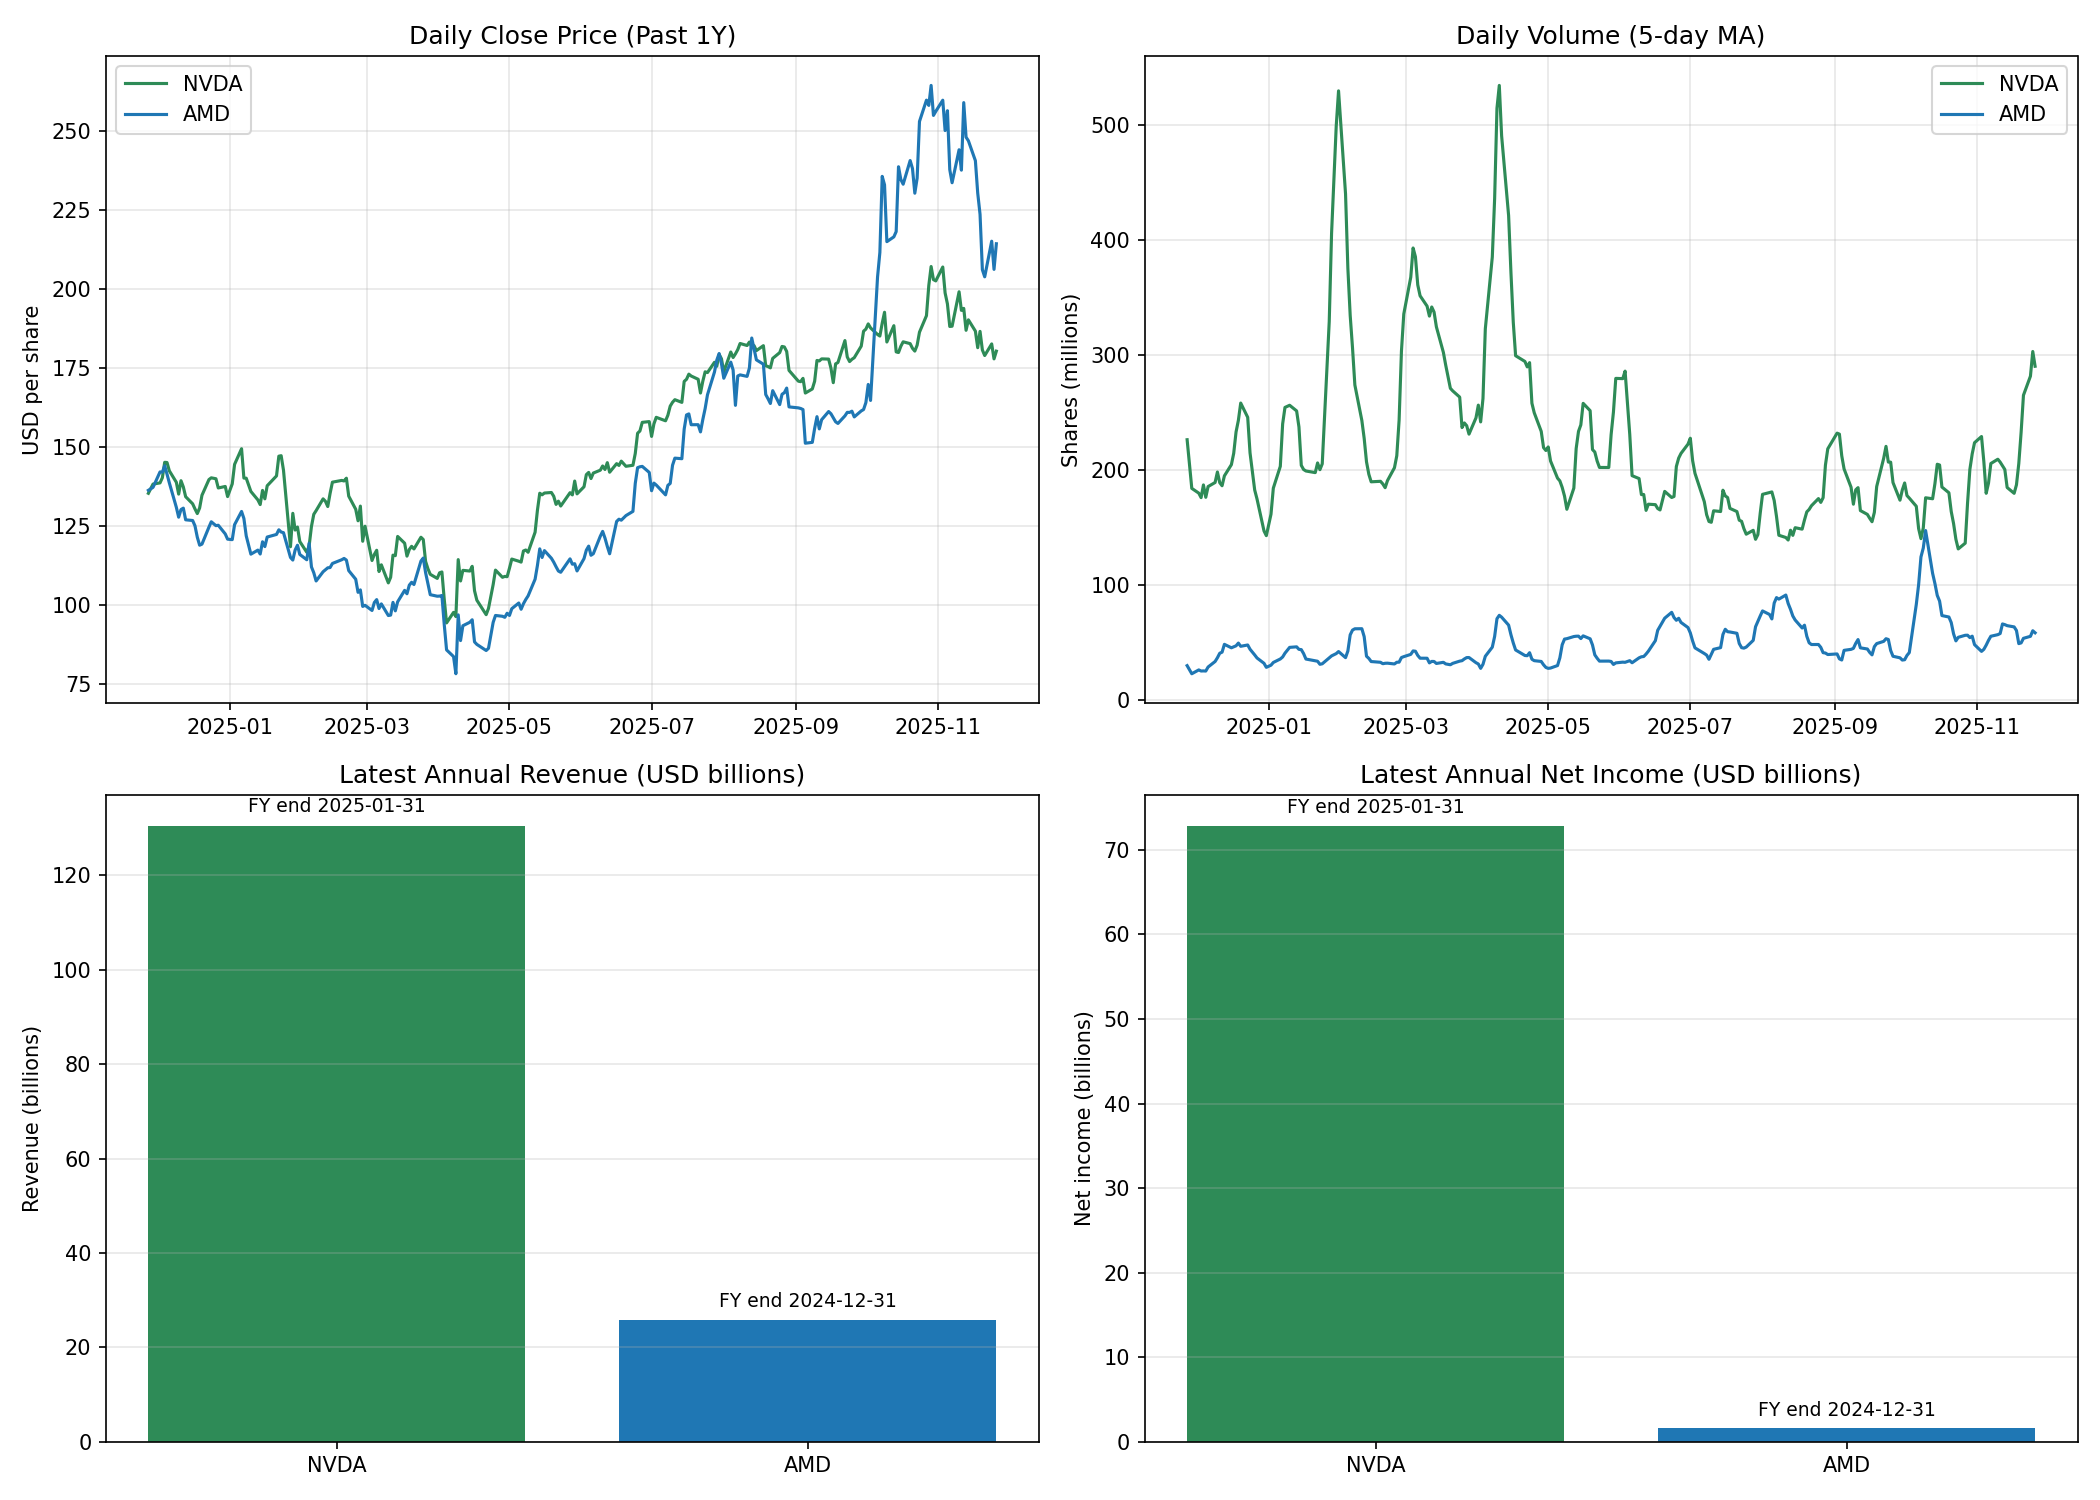


✅ Displayed 1 image(s)


In [9]:
# Display any images generated by the agent
display_sandbox_images(session.sandbox, "results")

In [10]:
# Display code file generated by agent
print("./")
print_sandbox_tree(session.sandbox, path="code/")

./
├── bash_0001.sh
├── bash_0002.sh
├── exec_0001.py
├── exec_0002.py
├── exec_0003.py
├── exec_0004.py
├── exec_0005.py
├── exec_0006.py
├── exec_0007.py
├── exec_0008.py
├── exec_0009.py
├── exec_0010.py
├── exec_0011.py
├── exec_0012.py
├── exec_0013.py
├── exec_0014.py
├── exec_0015.py
├── exec_0016.py
└── exec_0017.py


In [11]:
# Display results generated by agent
print("./")
print_sandbox_tree(session.sandbox, path="results/")

./
├── nvda_amd_2x2.png
├── nvda_amd_comparison.md
└── task_request.md


### Export Sandbox Files

Export all files from the sandbox to your local filesystem for inspection or archival.

In [12]:
# Export all sandbox files to local filesystem
# This downloads code/, data/, and results/ directories with timestamp organization
export_result = export_sandbox_files(session.sandbox)

# Dump agent messages to the same output directory for debugging
if export_result.success:
    messages_path = dump_messages(result["messages"], export_result.output_directory)
    print(f"Messages saved to: {messages_path}")

# Display the summary
print(export_result.summary())

📂 Discovering files in 'code'...
   Found 19 file(s)
📂 Discovering files in 'data'...
   Found 7 file(s)
📂 Discovering files in 'results'...
   Found 3 file(s)

✅ Export completed successfully!
   Exported 29 file(s) to: output/20251126_233555
Messages saved to: /Users/chen/projects/codeact-mcp/output/20251126_233555/messages.json

Export Summary (20251126_233555)
Output Directory: /Users/chen/projects/codeact-mcp/output/20251126_233555
Total Files: 29
Successfully Exported: 29
Failed: 0
Total Size: 317.06 KB

Directories Processed:
  - code
  - data
  - results



In [13]:
# Alternative: Export only specific directories
# Uncomment and run if you only want to export results
# export_result = export_sandbox_files(
#     session.sandbox,
#     directories=['results'],
#     output_base="my_exports",
#     timestamp_format="%Y-%m-%d_%H-%M"
# )
# print(export_result.summary())

In [14]:
# Cleanup session when done
await session.cleanup()

2025-11-26 23:35:59 [info     ] Cleaning up session            conversation_id=demo-notebook
2025-11-26 23:35:59 [info     ] Cleaning up sandbox            sandbox_id=7b8c3600-846d-4c07-b5e5-8a01900d098e
2025-11-26 23:36:00 [info     ] Sandbox deleted                sandbox_id=7b8c3600-846d-4c07-b5e5-8a01900d098e
2025-11-26 23:36:00 [info     ] Disconnecting from all MCP servers
2025-11-26 23:36:00 [info     ] Disconnecting from MCP server  server=tickertick
2025-11-26 23:36:00 [info     ] Disconnecting from MCP server  server=yfinance
2025-11-26 23:36:00 [debug    ] Disconnected from MCP server   server=tickertick
2025-11-26 23:36:00 [debug    ] Disconnected from MCP server   server=yfinance
2025-11-26 23:36:00 [info     ] Session cleaned up             conversation_id=demo-notebook
